1. Qual é a menor Temperatura em cada uma das estações?
    1. Em qual mês essa temperatura é alcançada?
2. Qual é a latitude e longitude do maior nível de água registrado?
    1. Em qual mês esse nível é normalmente alcançado?
3. Como o tamanho das ondas se relaciona com o nível do mar?
    1. É possível prever o tamanho das ondas utilizando a temperatura do mar?
    2. E a localização das estações?
    
    
Fonte dos dados: https://www.digitalocean.ie/ <br>
Período análise: 01/09/2021 ~ 01/09/2022

## Importando as Bibliotecas

In [ ]:
# Importa o findspark e inicializa
import findspark
findspark.init()


In [ ]:
# Imports
import numpy as np
import pandas as pd
import os
import pyspark
import seaborn as sns
from pyspark.sql.functions import when, col, regexp_replace, translate
import pyspark.sql.functions as F
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import SQLContext
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
os.environ['MAIN_APPLICATION'] = '/home/robson/rep/digital_ocean'
os.chdir(os.getenv('MAIN_APPLICATION'))

## Configurando Spark

In [ ]:
# Criando o Spark Context
sc = SparkContext(appName = "digital_ocean")

22/10/02 17:30:05 WARN Utils: Your hostname, robson-Lenovo-Y720-15IKB resolves to a loopback address: 127.0.1.1; using 192.168.1.7 instead (on interface wlp2s0)
22/10/02 17:30:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/02 17:30:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
sc.setLogLevel("ERROR")

In [ ]:
# Criando a sessão
spark = SparkSession.builder.getOrCreate()

In [ ]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.2.1 
 Master 
 local[8] 
 AppName 
 Databricks Shell

## Carregando a Base de Dados

### Ondas

#### Carga RDD - Pré-processamento

In [ ]:
dados_ondas_rdd = sc.textFile("data/dados_brutos/IWaveBNetwork30Min_*")


In [ ]:
# Número de registros
dados_ondas_rdd.count()

Out[7]: 258112

In [ ]:
# Visualizando as primeiras linhas
dados_ondas_rdd.take(5)

Out[8]: ['longitude,latitude,time,station_id,PeakPeriod,PeakDirection,UpcrossPeriod,SignificantWaveHeight,Hmax,SeaTemperature,MeanCurSpeed,MeanCurDirTo',
 'degrees_east,degrees_north,UTC,,s,degrees_true,s,cm,cm,degree_C,m/s,degrees_true',
 '-10.15099,54.2251,2021-09-01T12:02:00Z,AMETS Berth B Wave Buoy,9.09,308.0,5.0,42.0,NaN,15.1,NaN,NaN',
 '-10.15099,54.2251,2021-09-01T12:32:00Z,AMETS Berth B Wave Buoy,9.09,317.8,5.0,39.0,NaN,15.05,NaN,NaN',
 '-10.15099,54.2251,2021-09-01T13:02:00Z,AMETS Berth B Wave Buoy,8.33,313.6,4.651,41.0,NaN,15.0,NaN,NaN']

In [ ]:
# recuperando o nome das colunas
schema = dados_ondas_rdd.take(1)[0].split(',')

In [ ]:
# Removendo a as duas primeiras linhas de cabeçalho ('degrees_east,degrees_north,UTC,,s,degrees_true,s,cm,cm,degree_C,m/s,degrees_true')
dados_ondas_rdd = dados_ondas_rdd.filter(lambda x: "degrees_east" not in x and "longitude" not in x)
dados_ondas_rdd.count()

Out[10]: 258100

#### Spark Dataframe

In [ ]:
#Carregando base de dados spark dataframe
dados_ondas = dados_ondas_rdd.map(lambda x: str(x)).map(lambda w: w.split(',')).toDF(schema)

In [ ]:
dados_ondas.show()

+---------+--------+--------------------+--------------------+----------+-------------+-------------+---------------------+----+--------------+------------+------------+
|longitude|latitude|                time|          station_id|PeakPeriod|PeakDirection|UpcrossPeriod|SignificantWaveHeight|Hmax|SeaTemperature|MeanCurSpeed|MeanCurDirTo|
+---------+--------+--------------------+--------------------+----------+-------------+-------------+---------------------+----+--------------+------------+------------+
|-10.15099| 54.2251|2021-09-01T12:02:00Z|AMETS Berth B Wav...|      9.09|        308.0|          5.0|                 42.0| NaN|          15.1|         NaN|         NaN|
|-10.15099| 54.2251|2021-09-01T12:32:00Z|AMETS Berth B Wav...|      9.09|        317.8|          5.0|                 39.0| NaN|         15.05|         NaN|         NaN|
|-10.15099| 54.2251|2021-09-01T13:02:00Z|AMETS Berth B Wav...|      8.33|        313.6|        4.651|                 41.0| NaN|          15.0|       

In [ ]:
#quantidade linhas
dados_ondas.count()

Out[13]: 258100

In [ ]:
#schema
dados_ondas.printSchema()

root
 |-- longitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- time: string (nullable = true)
 |-- station_id: string (nullable = true)
 |-- PeakPeriod: string (nullable = true)
 |-- PeakDirection: string (nullable = true)
 |-- UpcrossPeriod: string (nullable = true)
 |-- SignificantWaveHeight: string (nullable = true)
 |-- Hmax: string (nullable = true)
 |-- SeaTemperature: string (nullable = true)
 |-- MeanCurSpeed: string (nullable = true)
 |-- MeanCurDirTo: string (nullable = true)



#### Processamento Dados

In [ ]:
# Convertendo tipos Numéricos
dados_ondas = dados_ondas.withColumn("longitude", dados_ondas["longitude"].cast("double"))\
    .withColumn("latitude", dados_ondas["latitude"].cast("double"))\
    .withColumn("PeakPeriod", dados_ondas["PeakPeriod"].cast("double"))\
    .withColumn("PeakDirection", dados_ondas["PeakDirection"].cast("double"))\
    .withColumn("UpcrossPeriod", dados_ondas["UpcrossPeriod"].cast("double"))\
    .withColumn("SignificantWaveHeight", dados_ondas["SignificantWaveHeight"].cast("double"))\
    .withColumn("Hmax", dados_ondas["Hmax"].cast("double"))\
    .withColumn("SeaTemperature", dados_ondas["SeaTemperature"].cast("double"))\
    .withColumn("MeanCurSpeed", dados_ondas["MeanCurSpeed"].cast("double"))\
    .withColumn("MeanCurDirTo", dados_ondas["MeanCurDirTo"].cast("double"))

In [ ]:
# Dividindo Coluna 'time' na coluna data e hora
split_col = pyspark.sql.functions.split(dados_ondas['time'], 'T')
dados_ondas = dados_ondas.withColumn('data', split_col.getItem(0))
dados_ondas = dados_ondas.withColumn('hora', split_col.getItem(1))

In [ ]:
dados_ondas.show(10)

+---------+--------+--------------------+--------------------+----------+-------------+-------------+---------------------+----+--------------+------------+------------+----------+---------+
|longitude|latitude|                time|          station_id|PeakPeriod|PeakDirection|UpcrossPeriod|SignificantWaveHeight|Hmax|SeaTemperature|MeanCurSpeed|MeanCurDirTo|      data|     hora|
+---------+--------+--------------------+--------------------+----------+-------------+-------------+---------------------+----+--------------+------------+------------+----------+---------+
|-10.15099| 54.2251|2021-09-01T12:02:00Z|AMETS Berth B Wav...|      9.09|        308.0|          5.0|                 42.0| NaN|          15.1|         NaN|         NaN|2021-09-01|12:02:00Z|
|-10.15099| 54.2251|2021-09-01T12:32:00Z|AMETS Berth B Wav...|      9.09|        317.8|          5.0|                 39.0| NaN|         15.05|         NaN|         NaN|2021-09-01|12:32:00Z|
|-10.15099| 54.2251|2021-09-01T13:02:00Z|AMET

In [ ]:
#dividindo coluna hora em hora e minuto
split_col = pyspark.sql.functions.split(dados_ondas['hora'], ':')
dados_ondas = dados_ondas.withColumn('minuto', split_col.getItem(1))
dados_ondas = dados_ondas.withColumn('hora', split_col.getItem(0))


In [ ]:
# Removendo coluna 'time'
dados_ondas = dados_ondas.drop('time')

In [ ]:
dados_ondas.show()

+---------+--------+--------------------+----------+-------------+-------------+---------------------+----+--------------+------------+------------+----------+----+------+
|longitude|latitude|          station_id|PeakPeriod|PeakDirection|UpcrossPeriod|SignificantWaveHeight|Hmax|SeaTemperature|MeanCurSpeed|MeanCurDirTo|      data|hora|minuto|
+---------+--------+--------------------+----------+-------------+-------------+---------------------+----+--------------+------------+------------+----------+----+------+
|-10.15099| 54.2251|AMETS Berth B Wav...|      9.09|        308.0|          5.0|                 42.0| NaN|          15.1|         NaN|         NaN|2021-09-01|  12|    02|
|-10.15099| 54.2251|AMETS Berth B Wav...|      9.09|        317.8|          5.0|                 39.0| NaN|         15.05|         NaN|         NaN|2021-09-01|  12|    32|
|-10.15099| 54.2251|AMETS Berth B Wav...|      8.33|        313.6|        4.651|                 41.0| NaN|          15.0|         NaN|     

In [ ]:
#ajustando tipo novas colunas
dados_ondas = dados_ondas.withColumn("data", dados_ondas["data"].cast("date"))\
    .withColumn("hora", dados_ondas["hora"].cast("int"))\
    .withColumn("minuto", dados_ondas["minuto"].cast("int"))

### Maré

#### Carga RDD - Pré-processamento

In [ ]:
# Carregando Arquivos
dados_mares_rdd = sc.textFile("data/dados_brutos/IrishNationalTideGaugeNetwork_*")

In [ ]:
# Número de registros
dados_mares_rdd.count()

Out[27]: 1833391

In [ ]:
# Visualizando as primeiras linhas
dados_mares_rdd.take(5)

Out[28]: ['time,station_id,latitude,longitude,Water_Level_LAT,Water_Level_OD_Malin,QC_Flag',
 'UTC,,degrees_north,degrees_east,metres,metres,',
 '2021-09-01T18:40:00Z,Rosslare,52.2546,-6.334861,0.809,-0.302,1',
 '2021-09-01T18:45:00Z,Rosslare,52.2546,-6.334861,0.809,-0.302,1',
 '2021-09-01T18:50:00Z,Rosslare,52.2546,-6.334861,0.811,-0.3,1']

In [ ]:
schema_mares = dados_mares_rdd.take(1)[0].split(',')

In [ ]:
# Removendo a as duas primeiras linhas de cabeçalho ('degrees_east,degrees_north,UTC,,s,degrees_true,s,cm,cm,degree_C,m/s,degrees_true')
dados_mares_rdd = dados_mares_rdd.filter(lambda x: "station_id" not in x and "degrees_north" not in x)
dados_mares_rdd.count()

Out[30]: 1833349

#### Spark Dataframe

In [ ]:
#Carregando base de dados spark dataframe
dados_mares = dados_mares_rdd.map(lambda x: str(x)).map(lambda w: w.split(',')).toDF(schema_mares)

In [ ]:
dados_mares.show()

+--------------------+----------+--------+---------+---------------+--------------------+-------+
|                time|station_id|latitude|longitude|Water_Level_LAT|Water_Level_OD_Malin|QC_Flag|
+--------------------+----------+--------+---------+---------------+--------------------+-------+
|2021-09-01T18:40:00Z|  Rosslare| 52.2546|-6.334861|          0.809|              -0.302|      1|
|2021-09-01T18:45:00Z|  Rosslare| 52.2546|-6.334861|          0.809|              -0.302|      1|
|2021-09-01T18:50:00Z|  Rosslare| 52.2546|-6.334861|          0.811|                -0.3|      1|
|2021-09-01T18:55:00Z|  Rosslare| 52.2546|-6.334861|          0.814|              -0.297|      1|
|2021-09-01T19:00:00Z|  Rosslare| 52.2546|-6.334861|          0.847|              -0.264|      1|
|2021-09-01T19:05:00Z|  Rosslare| 52.2546|-6.334861|           0.87|              -0.241|      1|
|2021-09-01T19:10:00Z|  Rosslare| 52.2546|-6.334861|          0.882|              -0.229|      1|
|2021-09-01T19:15:00

In [ ]:
#quantidade linhas
dados_mares.count()

Out[33]: 1833349

In [ ]:
#schema
dados_mares.printSchema()

root
 |-- time: string (nullable = true)
 |-- station_id: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- Water_Level_LAT: string (nullable = true)
 |-- Water_Level_OD_Malin: string (nullable = true)
 |-- QC_Flag: string (nullable = true)



#### Processamento Dados

In [ ]:
# Convertendo tipos Numéricos
dados_mares = dados_mares.withColumn("longitude", dados_mares["longitude"].cast("double"))\
    .withColumn("latitude", dados_mares["latitude"].cast("double"))\
    .withColumn("Water_Level_LAT", dados_mares["Water_Level_LAT"].cast("double"))\
    .withColumn("Water_Level_OD_Malin", dados_mares["Water_Level_OD_Malin"].cast("double"))\
    .withColumn("QC_Flag", dados_mares["QC_Flag"].cast("int"))

In [ ]:
# Dividindo Coluna 'time' na coluna data e hora
split_col = pyspark.sql.functions.split(dados_mares['time'], 'T')
dados_mares = dados_mares.withColumn('data', split_col.getItem(0))
dados_mares = dados_mares.withColumn('hora', split_col.getItem(1))

In [ ]:
dados_mares.show(10)

+--------------------+----------+--------+---------+---------------+--------------------+-------+----------+---------+
|                time|station_id|latitude|longitude|Water_Level_LAT|Water_Level_OD_Malin|QC_Flag|      data|     hora|
+--------------------+----------+--------+---------+---------------+--------------------+-------+----------+---------+
|2021-09-01T18:40:00Z|  Rosslare| 52.2546|-6.334861|          0.809|              -0.302|      1|2021-09-01|18:40:00Z|
|2021-09-01T18:45:00Z|  Rosslare| 52.2546|-6.334861|          0.809|              -0.302|      1|2021-09-01|18:45:00Z|
|2021-09-01T18:50:00Z|  Rosslare| 52.2546|-6.334861|          0.811|                -0.3|      1|2021-09-01|18:50:00Z|
|2021-09-01T18:55:00Z|  Rosslare| 52.2546|-6.334861|          0.814|              -0.297|      1|2021-09-01|18:55:00Z|
|2021-09-01T19:00:00Z|  Rosslare| 52.2546|-6.334861|          0.847|              -0.264|      1|2021-09-01|19:00:00Z|
|2021-09-01T19:05:00Z|  Rosslare| 52.2546|-6.334

In [ ]:
#dividindo coluna hora em hora e minuto
split_col = pyspark.sql.functions.split(dados_mares['hora'], ':')
dados_mares = dados_mares.withColumn('minuto', split_col.getItem(1))
dados_mares = dados_mares.withColumn('hora', split_col.getItem(0))


In [ ]:
# Removendo coluna 'time'
dados_mares = dados_mares.drop('time')

In [ ]:
#ajustando tipo novas colunas
dados_mares = dados_mares.withColumn("data", dados_mares["data"].cast("date"))\
    .withColumn("hora", dados_mares["hora"].cast("int"))\
    .withColumn("minuto", dados_mares["minuto"].cast("int"))

In [ ]:
dados_mares.show(10)

+----------+--------+---------+---------------+--------------------+-------+----------+----+------+
|station_id|latitude|longitude|Water_Level_LAT|Water_Level_OD_Malin|QC_Flag|      data|hora|minuto|
+----------+--------+---------+---------------+--------------------+-------+----------+----+------+
|  Rosslare| 52.2546|-6.334861|          0.809|              -0.302|      1|2021-09-01|  18|    40|
|  Rosslare| 52.2546|-6.334861|          0.809|              -0.302|      1|2021-09-01|  18|    45|
|  Rosslare| 52.2546|-6.334861|          0.811|                -0.3|      1|2021-09-01|  18|    50|
|  Rosslare| 52.2546|-6.334861|          0.814|              -0.297|      1|2021-09-01|  18|    55|
|  Rosslare| 52.2546|-6.334861|          0.847|              -0.264|      1|2021-09-01|  19|     0|
|  Rosslare| 52.2546|-6.334861|           0.87|              -0.241|      1|2021-09-01|  19|     5|
|  Rosslare| 52.2546|-6.334861|          0.882|              -0.229|      1|2021-09-01|  19|    10|


## Análise Dados

### Criando Registro para a Execucao de SQL

In [ ]:
dados_ondas.createOrReplaceTempView("dados_ondas")
dados_mares.createOrReplaceTempView("dados_mares")
sqlContext = SQLContext(sc)

/databricks/spark/python/pyspark/sql/context.py:82: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### Ánalise Informações Dados Ondas

- Não Existem dados duplicados
- Dados de 6 boiais diferentes

In [ ]:
# Verificando se existem dados duplicados
if dados_ondas.count() > dados_ondas.dropDuplicates().count():
    raise ValueError('Existem valores duplicados')

In [ ]:
dados_ondas.select(F.countDistinct("station_id")).show()

+--------------------------+
|count(DISTINCT station_id)|
+--------------------------+
|                         6|
+--------------------------+



In [ ]:
#recuperando a lista das estacoes
lista_estacoes = dados_ondas.select('station_id').dropDuplicates().collect()
lista_estacoes = [str(row[0]) for row in lista_estacoes]
lista_estacoes

Out[45]: ['AMETS Berth B Wave Buoy',
 'SmartBay Wave Buoy',
 'Clew Bay',
 'Brandon Bay',
 'AMETS Berth A Wave Buoy',
 'Bantry Bay']

### Ánalise Informações Dados Maré

In [ ]:
# Verificando se existem dados duplicados
if dados_mares.count() > dados_mares.dropDuplicates().count():
    raise ValueError('Existem valores duplicados')

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<command-2901074111258920> in <module>
      1 # Verificando se existem dados duplicados
      2 if dados_mares.count() > dados_mares.dropDuplicates().count():
----> 3     raise ValueError('Existem valores duplicados')

ValueError: Existem valores duplicados

In [ ]:
dados_mares = dados_mares.dropDuplicates()

In [ ]:
dados_mares.select(F.countDistinct("station_id")).show()

+--------------------------+
|count(DISTINCT station_id)|
+--------------------------+
|                        20|
+--------------------------+



In [ ]:
#recuperando a lista das estacoes
lista_estacoes = dados_mares.select('station_id').dropDuplicates().collect()
lista_estacoes = [str(row[0]) for row in lista_estacoes]
lista_estacoes

Out[49]: ['Rosslare',
 'Ballycotton Harbour',
 'Howth Water Level 1',
 'Kinvara - Unreferenced',
 'Dublin Port',
 'Union Hall Harbor',
 'Ballyglass Harbour',
 'Roonagh Pier',
 'Killybegs Port',
 'Kilrush Lough',
 'Aranmore Island - Leabgarrow',
 'Malin Head - Portmore Pier',
 'Wexford Harbour',
 'Dunmore East Harbour',
 'Sligo',
 'Skerries Harbour',
 'Castletownbere Port',
 'Inishmore',
 'Dingle Harbour',
 'Galway Port']

### Analisando a Temperatura

In [ ]:
#menor temperatura registrada
menor_temperatura = dados_ondas.select(pyspark.sql.functions.min("SeaTemperature")).first()[0]
menor_temperatura

Out[50]: 4.47

In [ ]:
  # criando um dataframe pandas com os dados estatísticos mensais
  df_estatisticas = dados_ondas.groupby(['station_id', F.month('data').alias('mes')])\
    .agg(F.count('SeaTemperature').alias('count'),
         F.mean('SeaTemperature').alias('temperatura_media'),
         F.stddev('SeaTemperature').alias('std'),
         F.min('SeaTemperature').alias('min'),
         F.expr('percentile(SeaTemperature, array(0.25))')[0].alias('%25'),
         F.expr('percentile(SeaTemperature, array(0.5))')[0].alias('%50'),
         F.expr('percentile(SeaTemperature, array(0.75))')[0].alias('%75'),
         F.max('SeaTemperature').alias('max')).toPandas()

In [ ]:
df_estatisticas.head()

,station_id,mes,count,temperatura_media,std,min,%25,%50,%75,max
0,AMETS Berth B Wave Buoy,11,1432,12.256425,0.385005,11.45,11.95,12.35,12.45,13.30
1,AMETS Berth B Wave Buoy,6,1413,13.170064,0.320768,12.15,13.05,13.20,13.35,14.75
2,AMETS Berth B Wave Buoy,2,1251,9.378737,0.241163,8.65,9.25,9.40,9.55,9.90
3,AMETS Berth B Wave Buoy,1,1177,9.446177,0.165402,9.05,9.30,9.45,9.60,9.80
4,AMETS Berth B Wave Buoy,5,1487,11.720814,0.479115,10.70,11.40,11.85,12.15,12.85


In [ ]:
# Temperatura Mínima em cada Estação e o respectivo mês dessa temperatura
df_estatisticas.pipe(lambda df: df.loc[:,['station_id', 'mes', 'min']])\
    .sort_values(['station_id','min'], ascending=True)\
    .drop_duplicates(subset='station_id', keep='first')\
    .sort_values(['min'], ascending=True)\
    .rename(columns={'min':'temperatura_minima'})\
    .reset_index(drop=True)

,station_id,mes,temperatura_minima
0,Brandon Bay,3,4.47
1,Bantry Bay,3,5.27
2,SmartBay Wave Buoy,1,5.31
3,Clew Bay,3,7.50
4,AMETS Berth B Wave Buoy,3,8.15
5,AMETS Berth A Wave Buoy,3,8.55


In [ ]:
# recuperando dados para plotar
df_plot = sqlContext.sql("""
    SELECT station_id as estacao, MONTH(data) AS mes, MEAN(SeaTemperature) AS temperatura_media
    FROM dados_ondas
    GROUP BY station_id, MONTH(data)
    order by mes""").toPandas()

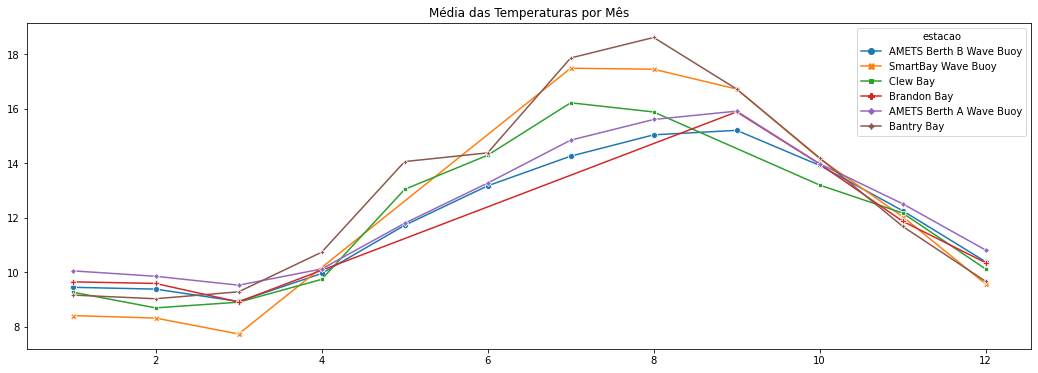

In [ ]:
ax = sns.lineplot(data=df_plot, x="mes", y="temperatura_media", hue="estacao", style="estacao", markers=True, dashes=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title("Média das Temperaturas por Mês")
ax.figure.set_size_inches(18, 6)


### Analisando a Altura Maré

In [ ]:
sqlContext.sql("""
    SELECT station_id as estacao, MAX(Water_Level_LAT) AS altura_maxima_mare
    FROM dados_mares
    GROUP BY station_id
    order by altura_maxima_mare desc""").show()

+--------------------+------------------+
|             estacao|altura_maxima_mare|
+--------------------+------------------+
|   Union Hall Harbor|               NaN|
|Kinvara - Unrefer...|               NaN|
| Howth Water Level 1|               NaN|
|Malin Head - Port...|            15.687|
|         Galway Port|             6.143|
|       Kilrush Lough|             6.042|
|           Inishmore|              5.61|
|    Skerries Harbour|             5.287|
|        Roonagh Pier|             5.117|
|      Dingle Harbour|             5.081|
|Dunmore East Harbour|             4.895|
|         Dublin Port|             4.783|
|Aranmore Island -...|             4.717|
| Ballycotton Harbour|             4.704|
|      Killybegs Port|             4.656|
|               Sligo|             4.584|
| Castletownbere Port|             4.272|
|  Ballyglass Harbour|             4.266|
|            Rosslare|              2.48|
|     Wexford Harbour|             2.286|
+--------------------+------------

In [ ]:
df_plot = sqlContext.sql("""
    SELECT 
        station_id as estacao, 
        latitude, 
        longitude, 
        MONTH(data) AS mes, 
        MEAN(Water_Level_LAT) AS altura_mare
    FROM dados_mares
    GROUP BY station_id, MONTH(data), latitude, longitude
    order by station_id,mes""").toPandas()

Out[113]: <matplotlib.legend.Legend at 0x7fd28c7eca30>

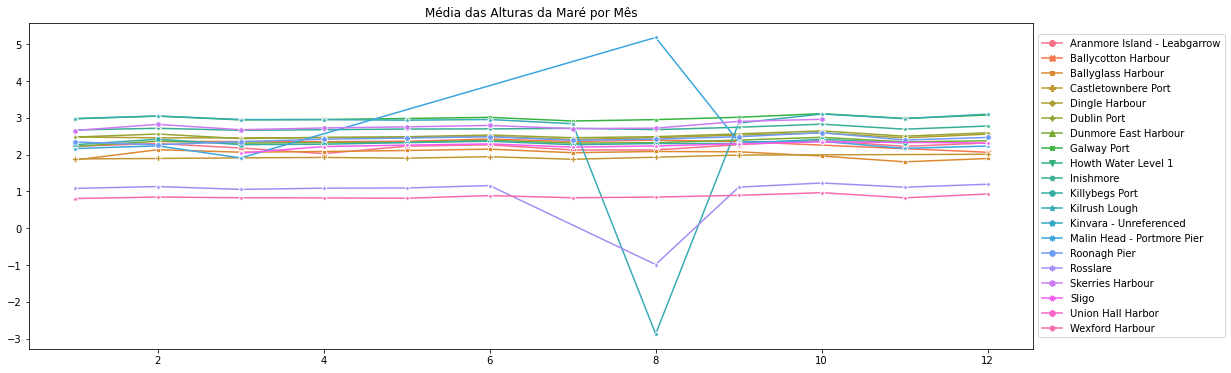

In [ ]:
# plotando todas as estações
ax = sns.lineplot(data=df_plot, x="mes", y="altura_mare", hue="estacao", style="estacao", markers=True, dashes=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title("Média das Alturas da Maré por Mês")
ax.figure.set_size_inches(18, 6)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Out[114]: <matplotlib.legend.Legend at 0x7fd28c6fabb0>

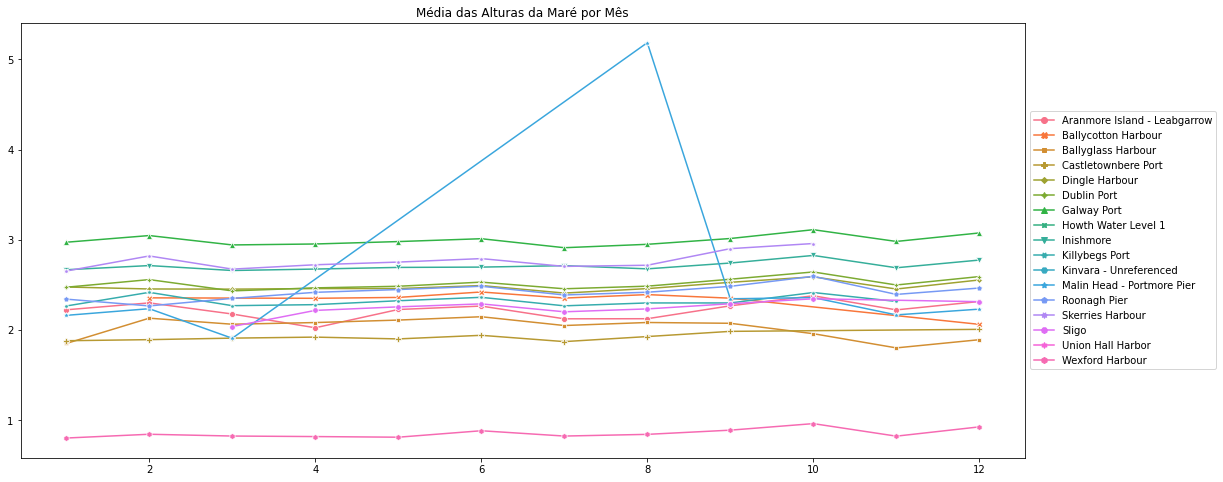

In [ ]:
# retirando a estação Dunmore, Kilrush, Rosslare

estacoes_fora_analise = ['Dunmore East Harbour', 'Kilrush Lough', 'Rosslare']

df_plot = df_plot.pipe(lambda df: df.loc[~df['estacao'].isin(estacoes_fora_analise)])
ax = sns.lineplot(data=df_plot, x="mes", y="altura_mare", hue="estacao", style="estacao", markers=True, dashes=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title("Média das Alturas da Maré por Mês")
ax.figure.set_size_inches(18, 8)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [ ]:
df_maiores_alturas = sqlContext.sql("""
    SELECT 
        station_id as estacao, 
        latitude, 
        longitude, 
        MONTH(data) AS mes, 
        MAX(Water_Level_LAT) AS altura_mare
    FROM dados_mares
    GROUP BY station_id, MONTH(data), latitude, longitude
    order by station_id,mes""").toPandas()

In [ ]:
df_maiores_alturas.sort_values(['estacao', 'altura_mare'], ascending=[True, False])\
    .drop_duplicates(['estacao'], keep='first')\
    .sort_values('altura_mare', ascending=False)\
    .dropna()\
    .reset_index(drop=True)

,estacao,latitude,longitude,mes,altura_mare
0,Malin Head - Portmore Pier,55.37170,-7.334400,8,15.687
1,Galway Port,53.26900,-9.048000,12,6.143
2,Kilrush Lough,52.63191,-9.502080,12,6.042
3,Inishmore,53.11780,-9.666900,12,5.610
4,Skerries Harbour,53.58500,-6.108100,2,5.287
5,Roonagh Pier,53.76235,-9.904420,12,5.117
6,Dingle Harbour,52.13924,-10.277320,12,5.081
7,Dunmore East Harbour,52.14767,-6.991880,2,4.895
8,Dublin Port,53.34570,-6.221700,1,4.783
9,Aranmore Island - Leabgarrow,54.99050,-8.495500,1,4.717


### Analisando a Relação entre Temperatura e localidade com o Tamanho das Ondas

In [ ]:
# Removendo NA dos dados para a análise
dados_ondas_analise = dados_ondas.na.drop(subset=["station_id", 'SignificantWaveHeight', 'SeaTemperature'])

In [ ]:
dados_ondas_analise.count()

Out[74]: 79240

In [ ]:
dados_ondas_analise.select('station_id').dropDuplicates().collect()

Out[75]: [Row(station_id='AMETS Berth B Wave Buoy'),
 Row(station_id='SmartBay Wave Buoy'),
 Row(station_id='Clew Bay'),
 Row(station_id='Brandon Bay'),
 Row(station_id='AMETS Berth A Wave Buoy'),
 Row(station_id='Bantry Bay')]

In [ ]:
dados_ondas_analise.show()

+---------+--------+--------------------+----------+-------------+-------------+---------------------+----+--------------+------------+------------+----------+----+------+
|longitude|latitude|          station_id|PeakPeriod|PeakDirection|UpcrossPeriod|SignificantWaveHeight|Hmax|SeaTemperature|MeanCurSpeed|MeanCurDirTo|      data|hora|minuto|
+---------+--------+--------------------+----------+-------------+-------------+---------------------+----+--------------+------------+------------+----------+----+------+
|-10.15099| 54.2251|AMETS Berth B Wav...|      9.09|        308.0|          5.0|                 42.0| NaN|          15.1|         NaN|         NaN|2021-09-01|  12|     2|
|-10.15099| 54.2251|AMETS Berth B Wav...|      9.09|        317.8|          5.0|                 39.0| NaN|         15.05|         NaN|         NaN|2021-09-01|  12|    32|
|-10.15099| 54.2251|AMETS Berth B Wav...|      8.33|        313.6|        4.651|                 41.0| NaN|          15.0|         NaN|     

In [ ]:
# criando variável localizacao
indexer = StringIndexer(inputCol="station_id", outputCol="local")
dados_ondas_analise = indexer.fit(dados_ondas_analise).transform(dados_ondas_analise)

In [ ]:
# Analisando correlação entre temperatura do mar e altura das ondes
dados_ondas_analise.stat.corr('SeaTemperature', 'SignificantWaveHeight')

Out[78]: -0.24602612730524154

In [ ]:
# Analisando correlação entre local e altura das ondas
dados_ondas_analise.stat.corr('local', 'SignificantWaveHeight')

Out[79]: -0.40430822397357313

In [ ]:
# Verificando quantos locais estão sendo analisados
dados_ondas_analise.select('local').dropDuplicates().collect()

Out[80]: [Row(local=0.0),
 Row(local=3.0),
 Row(local=4.0),
 Row(local=5.0),
 Row(local=1.0),
 Row(local=2.0)]

In [ ]:
dados_ondas_analise.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- station_id: string (nullable = true)
 |-- PeakPeriod: double (nullable = true)
 |-- PeakDirection: double (nullable = true)
 |-- UpcrossPeriod: double (nullable = true)
 |-- SignificantWaveHeight: double (nullable = true)
 |-- Hmax: double (nullable = true)
 |-- SeaTemperature: double (nullable = true)
 |-- MeanCurSpeed: double (nullable = true)
 |-- MeanCurDirTo: double (nullable = true)
 |-- data: date (nullable = true)
 |-- hora: integer (nullable = true)
 |-- minuto: integer (nullable = true)
 |-- local: double (nullable = false)



In [ ]:
df_plot = sqlContext.sql("""
    SELECT 
        station_id,
        MEAN(SeaTemperature) as temperatura_agua,
        MEAN(SignificantWaveHeight) as altura_onda, 
        MONTH(data) AS mes
    FROM dados_ondas
    where SignificantWaveHeight is not null 
    and SeaTemperature is not null
    GROUP BY MONTH(data), station_id
    order by mes""").toPandas()

In [ ]:
df_plot.head()

,station_id,temperatura_agua,altura_onda,mes
0,AMETS Berth B Wave Buoy,9.446177,366.917587,1
2,Clew Bay,9.267493,143.406425,1
4,AMETS Berth A Wave Buoy,10.049915,418.455319,1
6,AMETS Berth B Wave Buoy,9.378737,573.471623,2
8,Clew Bay,8.690587,202.942142,2


In [ ]:
df_plot.station_id.drop_duplicates()

Out[94]: 0    AMETS Berth B Wave Buoy
2                   Clew Bay
4    AMETS Berth A Wave Buoy
Name: station_id, dtype: object

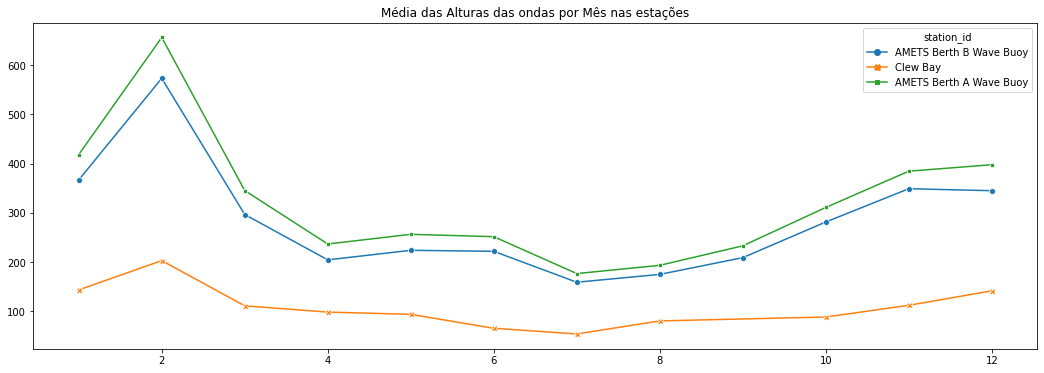

In [ ]:
ax = sns.lineplot(
    data=df_plot, 
    x="mes", 
    y="altura_onda", 
    markers=True, 
    dashes=False,
    hue="station_id", 
    style="station_id",
)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title("Média das Alturas das ondas por Mês nas estações")
ax.figure.set_size_inches(18, 6)

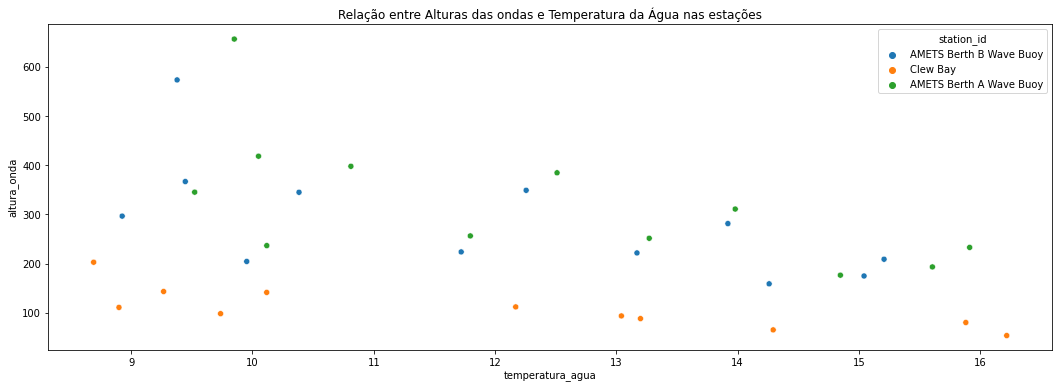

In [ ]:
ax = sns.scatterplot(data=df_plot, x="temperatura_agua", y="altura_onda",  hue="station_id")
ax.set_ylabel('altura_onda')
ax.set_xlabel('temperatura_agua')
ax.set_title("Relação entre Alturas das ondas e Temperatura da Água nas estações dados mensais")
ax.figure.set_size_inches(18, 6)

In [ ]:
df_plot_dados_diarios = sqlContext.sql("""
    SELECT 
        station_id,
        MEAN(SeaTemperature) as temperatura_agua,
        MEAN(SignificantWaveHeight) as altura_onda, 
        MONTH(data) AS mes,
        DAY(data) AS dia
    FROM dados_ondas
    where SignificantWaveHeight is not null 
    and SeaTemperature is not null
    GROUP BY DAY(data), MONTH(data), station_id
    order by mes""").toPandas()

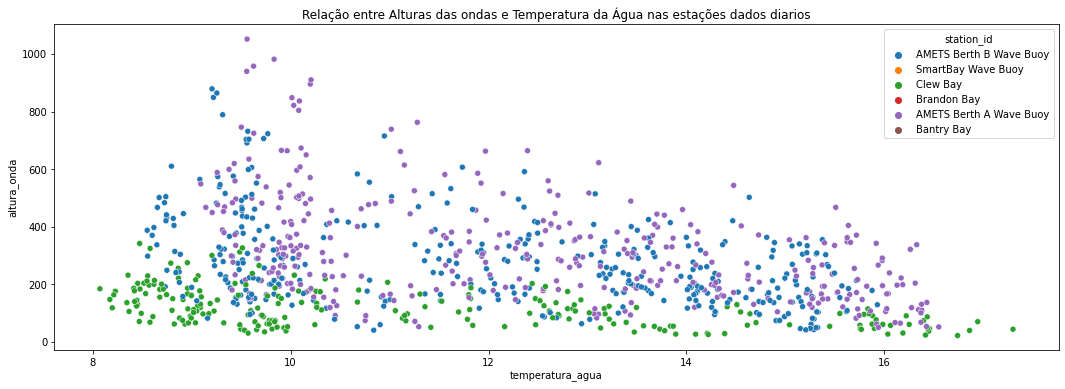

In [ ]:
ax = sns.scatterplot(data=df_plot_dados_diarios, x="temperatura_agua", y="altura_onda",  hue="station_id")
ax.set_ylabel('altura_onda')
ax.set_xlabel('temperatura_agua')
ax.set_title("Relação entre Alturas das ondas e Temperatura da Água nas estações dados diarios")
ax.figure.set_size_inches(18, 6)

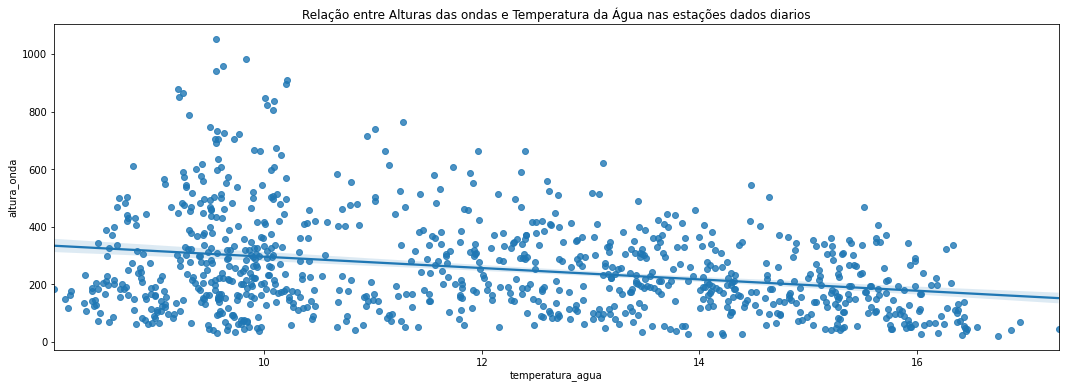

In [ ]:
ax = sns.regplot(data=df_plot_dados_diarios, x="temperatura_agua", y="altura_onda")
ax.set_ylabel('altura_onda')
ax.set_xlabel('temperatura_agua')
ax.set_title("Relação entre Alturas das ondas e Temperatura da Água nas estações dados diarios")
ax.figure.set_size_inches(18, 6)

#### Modelamento

In [ ]:
# Filtrndo colunas de interesse
dados_ondas_analise = dados_ondas_analise.select('SeaTemperature','local', 'SignificantWaveHeight')

In [ ]:
dados_ondas_analise.show()

+--------------+-----+---------------------+
|SeaTemperature|local|SignificantWaveHeight|
+--------------+-----+---------------------+
|          15.1|  0.0|                 42.0|
|         15.05|  0.0|                 39.0|
|          15.0|  0.0|                 41.0|
|          15.1|  0.0|                 42.0|
|          15.2|  0.0|                 43.0|
|         15.05|  0.0|                 40.0|
|         15.25|  0.0|                 41.0|
|          15.1|  0.0|                 43.0|
|          15.1|  0.0|                 42.0|
|          15.3|  0.0|                 46.0|
|         15.25|  0.0|                 43.0|
|          15.7|  0.0|                 48.0|
|         15.65|  0.0|                 49.0|
|          15.7|  0.0|                 50.0|
|          15.5|  0.0|                 49.0|
|          15.5|  0.0|                 53.0|
|          15.5|  0.0|                 51.0|
|         15.45|  0.0|                 51.0|
|         15.35|  0.0|                 47.0|
|         

In [ ]:
# transformando dados para formato esperado pelo modelo
dados_transformados_ondas=dados_ondas_analise.rdd.map(lambda x:(Vectors.dense(x[0:-1]), x[-1])).toDF(["features", "label"])
dados_transformados_ondas.show()

+-----------+-----+
|   features|label|
+-----------+-----+
| [15.1,0.0]| 42.0|
|[15.05,0.0]| 39.0|
| [15.0,0.0]| 41.0|
| [15.1,0.0]| 42.0|
| [15.2,0.0]| 43.0|
|[15.05,0.0]| 40.0|
|[15.25,0.0]| 41.0|
| [15.1,0.0]| 43.0|
| [15.1,0.0]| 42.0|
| [15.3,0.0]| 46.0|
|[15.25,0.0]| 43.0|
| [15.7,0.0]| 48.0|
|[15.65,0.0]| 49.0|
| [15.7,0.0]| 50.0|
| [15.5,0.0]| 49.0|
| [15.5,0.0]| 53.0|
| [15.5,0.0]| 51.0|
|[15.45,0.0]| 51.0|
|[15.35,0.0]| 47.0|
| [15.3,0.0]| 47.0|
+-----------+-----+
only showing top 20 rows



In [ ]:

dados_ondas_analise.select(F.mean('SignificantWaveHeight')).show()

+--------------------------+
|avg(SignificantWaveHeight)|
+--------------------------+
|         182.1421378091873|
+--------------------------+



In [ ]:
# divisão entre treino e teste
dados_treino, dados_teste = dados_transformados_ondas.randomSplit([0.8, 0.2], seed=256)

In [ ]:
regressor = LinearRegression()

# Treinamos a primeira versão do modelo sem validação cruzada
modelo = regressor.fit(dados_treino)

# Métricas do modelo
print('\033[1m' + "Modelo de Regressão Linear Sem Validação Cruzada:" + '\033[0m')
print("")

# Avalia o modelo com dados de teste
resultado_teste = modelo.evaluate(dados_teste)

# Imprime as métricas de erro do modelo com dados de teste
print("RMSE em Teste: {}".format(resultado_teste.rootMeanSquaredError))
print("Coeficiente R2 em Teste: {}".format(resultado_teste.r2))
print("")

Modelo de Regressão Linear Sem Validação Cruzada:

RMSE em Teste: 143.60019236548624
Coeficiente R2 em Teste: 0.23375821902848382



##### Modelamento utilizando validação cruzada

In [ ]:
# Prepara o grid de hiperparâmetros
paramGrid = (ParamGridBuilder().addGrid(regressor.regParam, [0.1, 0.01]).build())

# Cria os avaliadores
eval_rmse = RegressionEvaluator(metricName = "rmse")
eval_r2 = RegressionEvaluator(metricName = "r2")

# Cria o Cross Validator
crossval = CrossValidator(estimator = regressor,
                          estimatorParamMaps = paramGrid,
                          evaluator = eval_rmse,
                          numFolds = 3) 

print('\033[1m' + "Modelo de Regressão Linear Com Validação Cruzada:" + '\033[0m')
print("")

# Treina o modelo com validação cruzada
modelo = crossval.fit(dados_treino)

#recupera melhor modelo
LR_BestModel = modelo.bestModel

# Previsões com dados de teste
previsoes = LR_BestModel.transform(dados_teste)

# Avaliação do melhor modelo
resultado_teste_rmse = eval_rmse.evaluate(previsoes)
print('RMSE em Teste:', resultado_teste_rmse)

resultado_teste_r2 = eval_r2.evaluate(previsoes)
print('Coeficiente R2 em Teste:', resultado_teste_r2)
print("")

Modelo de Regressão Linear Com Validação Cruzada:

RMSE em Teste: 143.60025617179002
Coeficiente R2 em Teste: 0.23375753809531896



### Correlação entre as bases

In [ ]:
from geopy.distance import geodesic

In [ ]:
index_mares = sqlContext.sql("""
    SELECT 
        station_id as estacao, 
        latitude, 
        longitude
    FROM dados_mares
    GROUP BY station_id, latitude, longitude
    order by estacao""").toPandas()

In [ ]:
index_ondas = sqlContext.sql("""
    SELECT 
        station_id as estacao, 
        latitude, 
        longitude
    FROM dados_ondas
    GROUP BY station_id, latitude, longitude
    order by estacao""").toPandas()

In [ ]:
index_mares.head()

,estacao_mares,latitude_mares,longitude_mares
0,Aranmore Island - Leabgarrow,54.99050,-8.49550
1,Ballycotton Harbour,51.82780,-8.00070
2,Ballyglass Harbour,54.25360,-9.89280
3,Castletownbere Port,51.64960,-9.90340
4,Dingle Harbour,52.13924,-10.27732


In [ ]:
index_ondas.head()

,estacao_ondas,latitude_ondas,longitude_ondas
0,AMETS Berth A Wave Buoy,54.275300,-10.297370
1,AMETS Berth B Wave Buoy,54.225100,-10.150990
2,Bantry Bay,51.647000,-9.681000
3,Brandon Bay,52.282333,-10.094833
4,Clew Bay,53.801353,-9.911498


In [ ]:
index_mares.columns = ['estacao_mares', 'latitude_mares', 'longitude_mares']
index_ondas.columns = ['estacao_ondas', 'latitude_ondas', 'longitude_ondas']

In [ ]:
df_relacao_estacoes = pd.merge(index_mares, index_ondas, how='cross')

In [ ]:
df_relacao_estacoes.head()

,estacao_mares,latitude_mares,longitude_mares,estacao_ondas,latitude_ondas,longitude_ondas
0,Aranmore Island - Leabgarrow,54.9905,-8.4955,AMETS Berth A Wave Buoy,54.275300,-10.297370
1,Aranmore Island - Leabgarrow,54.9905,-8.4955,AMETS Berth B Wave Buoy,54.225100,-10.150990
2,Aranmore Island - Leabgarrow,54.9905,-8.4955,Bantry Bay,51.647000,-9.681000
3,Aranmore Island - Leabgarrow,54.9905,-8.4955,Brandon Bay,52.282333,-10.094833
4,Aranmore Island - Leabgarrow,54.9905,-8.4955,Clew Bay,53.801353,-9.911498


In [ ]:
df_relacao_estacoes['distancia'] = df_relacao_estacoes.apply(lambda df: geodesic((df.latitude_mares, df.longitude_mares), (df.latitude_ondas, df.longitude_ondas)).km, axis=1)

In [ ]:
df_relacao_estacoes.head()

,estacao_mares,latitude_mares,longitude_mares,estacao_ondas,latitude_ondas,longitude_ondas,distancia
0,Aranmore Island - Leabgarrow,54.9905,-8.4955,AMETS Berth A Wave Buoy,54.275300,-10.297370,140.981946
1,Aranmore Island - Leabgarrow,54.9905,-8.4955,AMETS Berth B Wave Buoy,54.225100,-10.150990,136.750496
2,Aranmore Island - Leabgarrow,54.9905,-8.4955,Bantry Bay,51.647000,-9.681000,380.384672
3,Aranmore Island - Leabgarrow,54.9905,-8.4955,Brandon Bay,52.282333,-10.094833,319.417670
4,Aranmore Island - Leabgarrow,54.9905,-8.4955,Clew Bay,53.801353,-9.911498,161.175075


In [ ]:
df_relacao_estacoes = df_relacao_estacoes.sort_values(['estacao_mares', 'distancia'], ascending=[True, True])\
    .drop_duplicates('estacao_mares', keep='first')\
    .pipe(lambda df: df.loc[:, ['estacao_mares', 'estacao_ondas']])\
    .reset_index(drop=True)

In [ ]:
df_relacao_estacoes.head()

,estacao_mares,estacao_ondas
0,Aranmore Island - Leabgarrow,AMETS Berth B Wave Buoy
1,Ballycotton Harbour,Bantry Bay
2,Ballyglass Harbour,AMETS Berth B Wave Buoy
3,Castletownbere Port,Bantry Bay
4,Dingle Harbour,Brandon Bay


In [ ]:
df_metricas_mensais_mares = sqlContext.sql("""
    SELECT 
        station_id as estacao_mares, 
        MONTH(data) AS mes, 
        MIN(Water_Level_LAT) AS altura_mare
    FROM dados_mares
    GROUP BY station_id, MONTH(data), latitude, longitude
    order by estacao_mares ,mes""").toPandas()

In [ ]:
df_metricas_mensais_ondas = sqlContext.sql("""
    SELECT 
        station_id as estacao_ondas, 
        latitude, 
        longitude,
        MEAN(SignificantWaveHeight) as altura_onda,
        MEAN(SeaTemperature) as temperatura,
        MONTH(data) AS mes
    FROM dados_ondas
    GROUP BY station_id, MONTH(data), latitude, longitude
    order by estacao_ondas ,mes""").toPandas()

In [ ]:
df_metricas_mensais_ondas = df_metricas_mensais_ondas.dropna()

In [ ]:
pd.merge(df_metricas_mensais_mares, df_relacao_estacoes, on='estacao_mares', how='left')

,estacao_mares,mes,altura_mare,estacao_ondas
0,Aranmore Island - Leabgarrow,1,0.116,AMETS Berth B Wave Buoy
1,Aranmore Island - Leabgarrow,2,0.236,AMETS Berth B Wave Buoy
2,Aranmore Island - Leabgarrow,3,0.026,AMETS Berth B Wave Buoy
3,Aranmore Island - Leabgarrow,4,0.437,AMETS Berth B Wave Buoy
4,Aranmore Island - Leabgarrow,5,0.347,AMETS Berth B Wave Buoy
...,...,...,...,...
212,Wexford Harbour,8,0.139,SmartBay Wave Buoy
213,Wexford Harbour,9,0.065,SmartBay Wave Buoy
214,Wexford Harbour,10,0.070,SmartBay Wave Buoy
215,Wexford Harbour,11,0.088,SmartBay Wave Buoy


In [ ]:
df_metricas_mensais_ondas

,estacao_ondas,latitude,longitude,altura_onda,temperatura,mes
0,AMETS Berth A Wave Buoy,54.275300,-10.297370,418.455319,10.049915,1
1,AMETS Berth A Wave Buoy,54.275300,-10.297370,656.521527,9.850203,2
2,AMETS Berth A Wave Buoy,54.275300,-10.297370,345.366283,9.523494,3
3,AMETS Berth A Wave Buoy,54.275300,-10.297370,236.731333,10.118144,4
4,AMETS Berth A Wave Buoy,54.275300,-10.297370,256.422478,11.796276,5
5,AMETS Berth A Wave Buoy,54.275300,-10.297370,251.589383,13.271077,6
6,AMETS Berth A Wave Buoy,54.275300,-10.297370,176.633754,14.847164,7
7,AMETS Berth A Wave Buoy,54.275300,-10.297370,193.399724,15.605824,8
8,AMETS Berth A Wave Buoy,54.275300,-10.297370,233.016725,15.912892,9
9,AMETS Berth A Wave Buoy,54.275300,-10.297370,311.027740,13.980176,10
